### This notebook generate the line benefits from the operational cost

In [1]:
# libraries
import os
import time
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# from kneed import KneeLocator
from pyomo.environ      import *
from pyomo.opt          import SolverFactory

In [2]:
#%% Defining the clustering functions
def KMeansMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmeans_pca = KMeans(n_clusters=OptClusters, init='k-means++', random_state=42)
    kmeans_pca.fit(Y_sklearn)
    df_segm_pca_kmeans = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmeans.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmeans_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-means PCA'] = kmeans_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Scenario', 'Period', 'Day', 'Month', 'Segment K-means PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-means PCA'] = np.where(data['Variable'] == df['Variable'],
                                                    df['Segment K-means PCA'], df['Segment K-means PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 1
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-means PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                       5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9',
                                                                       9: 'st10',
                                                                       10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14',
                                                                       14: 'st15',
                                                                       15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19',
                                                                       19: 'st20',
                                                                       20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24',
                                                                       24: 'st25',
                                                                       25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29',
                                                                       29: 'st30',
                                                                       30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34',
                                                                       34: 'st35',
                                                                       35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39',
                                                                       39: 'st40',
                                                                       40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44',
                                                                       44: 'st45',
                                                                       45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49',
                                                                       49: 'st50'})
    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    data = data[
        ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # TableToFile['Duration'] = 1
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa / 24
    dfa = dfa.sort_index()
    dfStages = pd.Series(dfa.values, index=dfa.index).to_frame(name='Weight')
    # dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)


def KMedoidsMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmedoids_pca = KMedoids(metric="euclidean", n_clusters=OptClusters, init="heuristic", max_iter=2, random_state=42)
    kmedoids_pca.fit(Y_sklearn)
    df_segm_pca_kmedoids = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmedoids.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmedoids['Segment K-medoids PCA'] = kmedoids_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmedoids.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmedoids_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-medoids PCA'] = kmedoids_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Day', 'Month', 'Segment K-medoids PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-medoids PCA'] = np.where(data['Variable'] == df['Variable'], df['Segment K-medoids PCA'], df['Segment K-medoids PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 0
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-medoids PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                         5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9', 9: 'st10',
                                                                         10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14', 14: 'st15',
                                                                         15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19', 19: 'st20',
                                                                         20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24', 24: 'st25',
                                                                         25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29', 29: 'st30',
                                                                         30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34', 34: 'st35',
                                                                         35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39', 39: 'st40',
                                                                         40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44', 44: 'st45',
                                                                         45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49', 49: 'st50',
                                                                         50: 'st51', 51: 'st52', 52: 'st53', 53: 'st54', 54: 'st55',
                                                                         55: 'st56', 56: 'st57', 57: 'st58', 58: 'st59', 59: 'st60',
                                                                         60: 'st61', 61: 'st62', 62: 'st63', 63: 'st64', 64: 'st65',
                                                                         65: 'st66', 66: 'st67', 67: 'st68', 68: 'st69', 69: 'st70',
                                                                         70: 'st71', 71: 'st72', 72: 'st73', 73: 'st74', 74: 'st75',
                                                                         75: 'st76', 76: 'st77', 77: 'st78', 78: 'st79', 79: 'st80',
                                                                         80: 'st81', 81: 'st82', 82: 'st83', 83: 'st84', 84: 'st85',
                                                                         85: 'st86', 86: 'st87', 87: 'st88', 88: 'st89', 89: 'st90',
                                                                         90: 'st91', 91: 'st92', 92: 'st93', 93: 'st94', 94: 'st95',
                                                                         95: 'st96', 96: 'st97', 97: 'st98', 98: 'st99', 99: 'st100',
                                                                         100: 'st101', 101: 'st102', 102: 'st103', 103: 'st104', 104: 'st105',
                                                                         105: 'st106', 106: 'st107', 107: 'st108', 108: 'st109', 109: 'st110',
                                                                         110: 'st111', 111: 'st112', 112: 'st113', 113: 'st114', 114: 'st115',
                                                                         115: 'st116', 116: 'st117', 117: 'st118', 118: 'st119', 119: 'st120',
                                                                         120: 'st121', 121: 'st122', 122: 'st123', 123: 'st124', 124: 'st125',
                                                                         125: 'st126', 126: 'st127', 127: 'st128', 128: 'st129', 129: 'st130',
                                                                         130: 'st131', 131: 'st132', 132: 'st133', 133: 'st134', 134: 'st135',
                                                                         135: 'st136', 136: 'st137', 137: 'st138', 138: 'st139', 139: 'st140',
                                                                         140: 'st141', 141: 'st142', 142: 'st143', 143: 'st144', 144: 'st145',
                                                                         145: 'st146', 146: 'st147', 147: 'st148', 148: 'st149', 149: 'st150',
                                                                         150: 'st151', 151: 'st152', 152: 'st153', 153: 'st154', 154: 'st155',
                                                                         155: 'st156', 156: 'st157', 157: 'st158', 158: 'st159', 159: 'st160'})

    #
    idx = kmedoids_pca.medoid_indices_
    dfDayToStage = pd.DataFrame(idx, columns=['Day'])
    dfDayToStage = dfDayToStage + 1
    for k in dfDayToStage.index:
        data.loc[data['Day'] == dfDayToStage['Day'][k], 'Duration'] = 1

    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    # data = data[
        # ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Duration', 'Value']]
    data = data[
        ['LoadLevel', 'Stage', 'Execution', 'Duration', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    # TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
    #                              columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['Execution'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa/24
    dfa = dfa.sort_index()
    dfStages = pd.Series(dfa.values, index=dfa.index).to_frame(name='Weight')
    dfStages.index.name = None
    # dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)

    return kmedoids_pca

### Reading the data for clustering

In [3]:
#%% Setting up the path a cases
DirName  = os.getcwd()

CaseName_Base     = '9n'
CaseName_ByStages = CaseName_Base + '_ByStages'

CSV_name =  'oT_Result_GenerationCost_' + CaseName_Base

_path_0 = os.path.join(DirName, CaseName_Base)
_path_1 = os.path.join(DirName, CaseName_ByStages)

StartTime = time.time()

#%% Selecting the maximum number of cluster to plot
max_cluster = 300
#%% Selecting the optimal number of cluster and defining the clustering method (0: k-means; 1:k-medoids)
# opt_cluster = 150
cluster_method = 1

output_directory = DirName + '/' + CaseName_ByStages + '/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


In [4]:
df_1 = pd.read_csv(_path_0+'/3.Out'+'/'+CSV_name+'.csv', index_col=[0,1,2])
diff_df_1 = df_1

In [5]:
#%% Loading Sets from CSV
dictSets = DataPortal()
dictSets.load(filename=_path_0+'/1.Set'+'/oT_Dict_LoadLevel_'   +CaseName_Base+'.csv', set='n'   , format='set')

#### Line benefits

In [6]:
diff_df_1.head()

,Scenario,LoadLevel,MEUR
Period,,,
2030,sc01,01-01 00:00:00+01:00,0.074437
2030,sc01,01-01 01:00:00+01:00,0.068985
2030,sc01,01-01 02:00:00+01:00,0.063302
2030,sc01,01-01 03:00:00+01:00,0.058141
2030,sc01,01-01 04:00:00+01:00,0.054130


In [7]:
diff_df_1['LoadLevel'] = dictSets['n' ]
diff_df_1.set_index('LoadLevel', inplace=True)

In [8]:
diff_df_1.head()

,Scenario,MEUR
LoadLevel,,
01-01 00:00:00+01:00,sc01,0.074437
01-01 01:00:00+01:00,sc01,0.068985
01-01 02:00:00+01:00,sc01,0.063302
01-01 03:00:00+01:00,sc01,0.058141
01-01 04:00:00+01:00,sc01,0.054130


In [9]:
# Selecting the columns demand, wind, solar, hydro
diff_df_1 = diff_df_1[['MEUR']]

In [10]:
ddf_1 = diff_df_1.stack()

In [11]:
ddf_1.index.names = ['LoadLevel', 'Execution']

In [12]:
# changing the column name
ddf_1 = ddf_1.to_frame(name='Value')

In [13]:
ddf_1.head()

,,Value
LoadLevel,Execution,
01-01 00:00:00+01:00,MEUR,0.074437
01-01 01:00:00+01:00,MEUR,0.068985
01-01 02:00:00+01:00,MEUR,0.063302
01-01 03:00:00+01:00,MEUR,0.058141
01-01 04:00:00+01:00,MEUR,0.054130


In [14]:
ddf_1 = ddf_1.reset_index()

In [15]:
ddf_1['Date'] = ddf_1['LoadLevel']
ddf_1['Date'] = ddf_1['Date'].str.slice(0, -6)

In [16]:
ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%m-%d %H:%M:%S', errors='coerce')

In [17]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date
8731,12-30 19:00:00+01:00,MEUR,0.098697,1900-12-30 19:00:00
8732,12-30 20:00:00+01:00,MEUR,0.095792,1900-12-30 20:00:00
8733,12-30 21:00:00+01:00,MEUR,0.096120,1900-12-30 21:00:00
8734,12-30 22:00:00+01:00,MEUR,0.091596,1900-12-30 22:00:00
8735,12-30 23:00:00+01:00,MEUR,0.083686,1900-12-30 23:00:00


#### Getting day of year and month

In [18]:
ddf_1['Hour' ] = ddf_1['Date'].dt.hour
ddf_1['Day'  ] = ddf_1['Date'].dt.dayofyear
ddf_1['Week' ] = ddf_1['Date'].dt.isocalendar().week
ddf_1['Month'] = ddf_1['Date'].dt.month

In [19]:
ddf_1.head()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month
0,01-01 00:00:00+01:00,MEUR,0.074437,1900-01-01 00:00:00,0,1,1,1
1,01-01 01:00:00+01:00,MEUR,0.068985,1900-01-01 01:00:00,1,1,1,1
2,01-01 02:00:00+01:00,MEUR,0.063302,1900-01-01 02:00:00,2,1,1,1
3,01-01 03:00:00+01:00,MEUR,0.058141,1900-01-01 03:00:00,3,1,1,1
4,01-01 04:00:00+01:00,MEUR,0.054130,1900-01-01 04:00:00,4,1,1,1


#### Generation new ID considering each line, and hour

In [20]:
ddf_1['Variable'] = ddf_1['Execution'] + '_' + ddf_1['Hour'].astype(str)

In [21]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month,Variable
8731,12-30 19:00:00+01:00,MEUR,0.098697,1900-12-30 19:00:00,19,364,52,12,MEUR_19
8732,12-30 20:00:00+01:00,MEUR,0.095792,1900-12-30 20:00:00,20,364,52,12,MEUR_20
8733,12-30 21:00:00+01:00,MEUR,0.096120,1900-12-30 21:00:00,21,364,52,12,MEUR_21
8734,12-30 22:00:00+01:00,MEUR,0.091596,1900-12-30 22:00:00,22,364,52,12,MEUR_22
8735,12-30 23:00:00+01:00,MEUR,0.083686,1900-12-30 23:00:00,23,364,52,12,MEUR_23


In [22]:
table = pd.pivot_table(ddf_1, values='Value', index=['Month', 'Day'], columns=['Variable'], aggfunc=np.sum)

In [23]:
table.tail()

Variable     MEUR_0    MEUR_1   MEUR_10   MEUR_11   MEUR_12   MEUR_13  \
Month Day                                                               
12    360  0.000000  0.000000  0.041578  0.043250  0.044798  0.053458   
      361  0.078702  0.066430  0.032341  0.033516  0.035322  0.042454   
      362  0.053021  0.046926  0.030012  0.029757  0.032408  0.037288   
      363  0.064334  0.054090  0.027872  0.027026  0.028742  0.035127   
      364  0.074997  0.065512  0.048730  0.034906  0.031634  0.039693   

Variable    MEUR_14   MEUR_15   MEUR_16   MEUR_17  ...   MEUR_21   MEUR_22  \
Month Day                                          ...                       
12    360  0.066464  0.076608  0.087104  0.092835  ...  0.100245  0.095370   
      361  0.048569  0.048800  0.047914  0.050439  ...  0.082956  0.074636   
      362  0.043559  0.057523  0.082909  0.096358  ...  0.095732  0.087881   
      363  0.042906  0.057372  0.085186  0.105559  ...  0.107955  0.098655   
      364  0.047169  0.061279  0.084891  0.098500  ...  0.096120  0.091596   

Variable    MEUR_23    MEUR_3    MEUR_4    MEUR_5    MEUR_6    MEUR_7  \
Month Day                                                               
12    360  0.088121  0.007436  0.018162  0.026722  0.035959  0.042243   
      361  0.062150  0.054879  0.051434  0.049443  0.049456  0.052464   
      362  0.075996  0.039709  0.040237  0.045664  0.056640  0.070256   
      363  0.085904  0.044504  0.043927  0.046578  0.054285  0.065489   
      364  0.083686  0.058283  0.057257  0.058878  0.065108  0.075492   

Variable     MEUR_8    MEUR_9  
Month Day                      
12    360  0.040926  0.039800  
      361  0.040542  0.031490  
      362  0.056523  0.038205  
      363  0.053409  0.034496  
      364  0.072393  0.060404  

[5 rows x 24 columns]

In [24]:
table = table.reset_index()

In [25]:
table = table.set_index(['Day'])

In [26]:
table.tail()

Variable,Month,MEUR_0,MEUR_1,MEUR_10,MEUR_11,MEUR_12,MEUR_13,MEUR_14,MEUR_15,MEUR_16,...,MEUR_21,MEUR_22,MEUR_23,MEUR_3,MEUR_4,MEUR_5,MEUR_6,MEUR_7,MEUR_8,MEUR_9
Day,,,,,,,,,,,,,,,,,,,,,
360,12,0.000000,0.000000,0.041578,0.043250,0.044798,0.053458,0.066464,0.076608,0.087104,...,0.100245,0.095370,0.088121,0.007436,0.018162,0.026722,0.035959,0.042243,0.040926,0.039800
361,12,0.078702,0.066430,0.032341,0.033516,0.035322,0.042454,0.048569,0.048800,0.047914,...,0.082956,0.074636,0.062150,0.054879,0.051434,0.049443,0.049456,0.052464,0.040542,0.031490
362,12,0.053021,0.046926,0.030012,0.029757,0.032408,0.037288,0.043559,0.057523,0.082909,...,0.095732,0.087881,0.075996,0.039709,0.040237,0.045664,0.056640,0.070256,0.056523,0.038205
363,12,0.064334,0.054090,0.027872,0.027026,0.028742,0.035127,0.042906,0.057372,0.085186,...,0.107955,0.098655,0.085904,0.044504,0.043927,0.046578,0.054285,0.065489,0.053409,0.034496
364,12,0.074997,0.065512,0.048730,0.034906,0.031634,0.039693,0.047169,0.061279,0.084891,...,0.096120,0.091596,0.083686,0.058283,0.057257,0.058878,0.065108,0.075492,0.072393,0.060404


#### Split data table into data X and class labels y

In [27]:
X = table.iloc[:,1:len(table.columns)+1].values
y = table.iloc[:,0].values

In [28]:
print(X)
print(y)

[[0.07443695 0.06898522 0.00348409 ... 0.05477828 0.03209201 0.00951501]
 [0.07858178 0.06840355 0.         ... 0.0599591  0.03705562 0.01565434]
 [0.04479848 0.03541063 0.00457116 ... 0.0411517  0.01767366 0.00539958]
 ...
 [0.0530208  0.04692618 0.03001239 ... 0.07025583 0.05652323 0.03820483]
 [0.06433449 0.05408955 0.02787241 ... 0.06548938 0.05340939 0.03449574]
 [0.0749975  0.06551242 0.04872995 ... 0.07549201 0.07239281 0.06040378]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7

## PCA step by step

#### Standardizing of the data

In [29]:
X_std = StandardScaler().fit_transform(X)

#### Eigendecomposition of the raw data based on the correlation matrix:

In [30]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 1.92963930e-01  2.81929078e-01 -2.95371207e-02 -1.03846067e-01
   3.30258428e-01 -3.56824667e-01  4.16552930e-02  3.59835128e-01
  -1.41398019e-01 -1.13179318e-01 -2.23456806e-01 -8.54063135e-03
   2.85924924e-01 -5.93114313e-02 -2.40007657e-01  2.94634375e-01
   2.30924928e-01  2.48676146e-02 -3.62994235e-02  7.65119746e-03
  -3.32111412e-01 -9.70118295e-02 -1.25040923e-01 -2.92445742e-02]
 [ 1.93544484e-01  3.02097766e-01 -2.97779258e-02 -9.66258129e-02
   2.67336097e-01 -2.68270450e-01  1.51912034e-02  1.26121474e-01
   3.40357294e-02  3.24474226e-02 -1.50737465e-01 -6.19437851e-04
  -1.74283840e-02 -1.14124191e-02  7.62553086e-02 -2.25891077e-01
  -2.11216869e-01  4.12715963e-02 -4.86265669e-02 -8.93889548e-02
   5.18614281e-01  1.38346259e-01  5.02724614e-01  1.47535645e-01]
 [ 2.11043880e-01 -1.02345217e-01 -2.61367020e-01 -5.78514746e-02
  -2.43206396e-01 -3.24104293e-01 -1.06138183e-01 -3.24031168e-01
   5.99925030e-02  5.28188393e-02 -4.74052388e-01  9.3483240

#### Selecting Principal Components

### Sorting Eigenpairs

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [31]:
# for ev in eig_vecs:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')

The common approach is to rank the eigenvalues from highest to lowest in order choose the top k eigenvectors.

In [32]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
16.04177088842648
3.653919752363635
2.44413376623907
0.6878803548570223
0.5077823187601389
0.25522996008142856
0.17118364813310893
0.07679849223982729
0.05466227109591576
0.03902743816687379
0.03330272416934798
0.022430462048270837
0.020083031305316572
0.013568137007784458
0.011955500988252347
0.008563343264137385
0.006480248737329006
0.004769730362227911
0.0038162736272843354
0.0033435074839889122
0.0029879818568504346
0.0012158789367179995
0.0008881365999448926
0.0003218557283863791


### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [33]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [34]:
i = 0
cum = 0
while cum < 97:
    cum += var_exp[i]
    print(cum, i)
    i += 1

66.65708370534355 0
81.83992333570069 1
91.99583630668035 2
94.85413036360684 3
96.96407749856483 4
98.02461407719989 5


Then

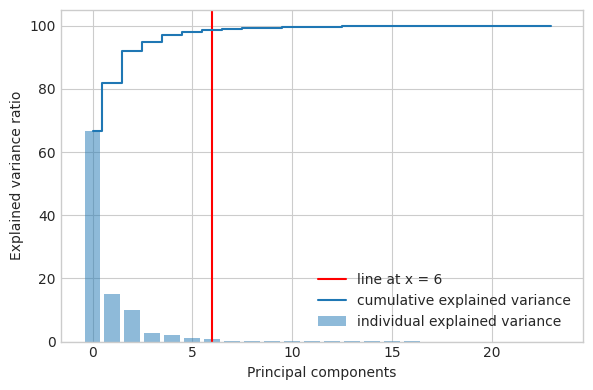

In [35]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=i, label='line at x = {}'.format(i), c='r')
    plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(table.columns)-1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig1.png', format='png', dpi=1200)
plt.show()

In [36]:
labels = np.unique(y, axis=0)

In [37]:
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Data distribution in relevant components

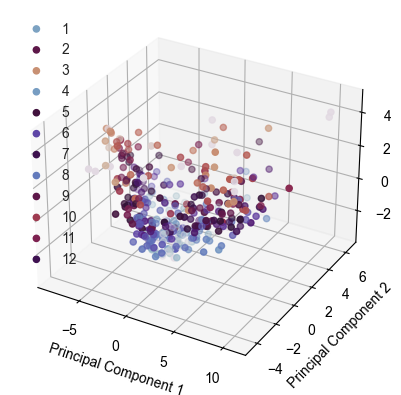

In [38]:
sklearn_pca = sklearnPCA(n_components=i)
Y_sklearn = sklearn_pca.fit_transform(X_std)

ax = plt.axes(projection='3d')
with plt.style.context('seaborn-whitegrid'):
#     plt.figure(figsize=(8, 6))
    for lab in labels:
#         plt.scatter(Y_sklearn[y==lab, 0],
#                     Y_sklearn[y==lab, 1],
#                     label=lab)
        zdata = Y_sklearn[y==lab, 2]
        xdata = Y_sklearn[y==lab, 0]
        ydata = Y_sklearn[y==lab, 1]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, label=lab, cmap='twilight');
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(loc="best")
#     plt.legend(loc='best')
#     plt.tight_layout()
    plt.savefig(_path_1+'/Fig2.png', format='png', dpi=1200)
    plt.show()

### Variance of each component

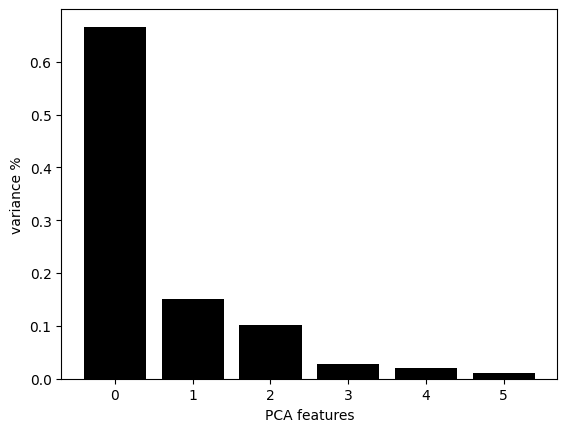

In [39]:
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig(_path_1+'/Fig3.png', format='png', dpi=1200)
plt.show()

In [40]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(Y_sklearn)

In [41]:
PCA_components.head()

,0,1,2,3,4,5
0,0.884953,-0.705965,-1.870499,0.026580,1.056973,-0.081208
1,-1.184081,-2.134014,-0.101678,0.407210,0.432446,-0.377606
2,-1.384374,0.966299,-1.714865,0.411608,0.454752,-0.088287
3,0.462209,0.085149,-2.475332,0.103090,0.217062,-0.117593
4,4.735781,0.596334,0.556060,-0.096410,-0.205011,-0.214845


### Getting the optimal number of clusters

c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\erik_\miniconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\erik_\miniconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\erik_\miniconda3\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 16: invalid start byte
c:\Users\erik_\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for 

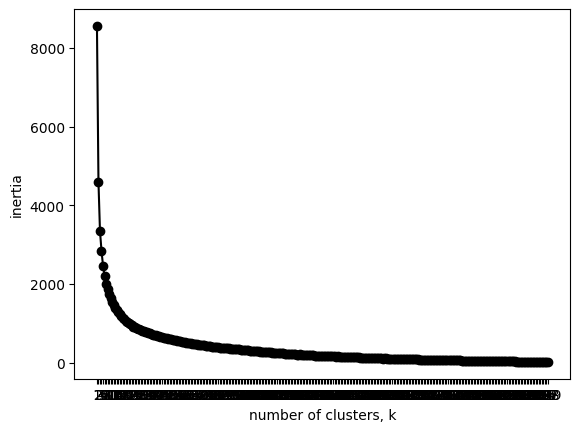

In [42]:
ks = range(1, max_cluster)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:i])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig(_path_1+'/Fig4.png', format='png', dpi=1200)
plt.show()

In [43]:
opt_cluster = 0
for k in range(len(inertias)-1):
    diff = abs(inertias[k]-inertias[k+1])/inertias[k]*100
    if diff > 0.1:
        opt_cluster += 1
    else:
        break
print("Optimal number of clusters: ", opt_cluster)

Optimal number of clusters:  38


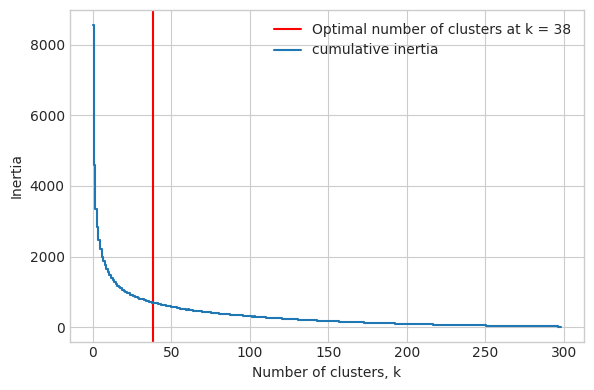

In [44]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=opt_cluster, label='Optimal number of clusters at k = {}'.format(opt_cluster), c='r')
    # plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            # label='individual explained variance')
    plt.step(range(len(inertias)), inertias, where='mid',
             label='cumulative inertia')
    
    plt.ylabel('Inertia')
    plt.xlabel('Number of clusters, k')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig5.png', format='png', dpi=1200)
plt.show()

### %opt_cluster Five clusters are chosen, so we run K-medoids with number of clusters equals four.
### Same initializer and random state as before

In [45]:
#%% Clustering method
print("Clustering")
if cluster_method == 0:
    KMeansMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, data)
elif cluster_method == 1:
    results = KMedoidsMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, ddf_1)
print('End of the process...')

Clustering
End of the process...


c:\Users\erik_\miniconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
